Uncomment this line to install the circlify package.

In [1]:
#!pip install circlify

In [2]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from pathlib import Path
import re
import circlify
import pyarrow.parquet as pq
from collections import defaultdict
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
sns.set_style("white")

In [3]:
sns.set_palette(
    [
        np.array(list(map(int, re.findall(r"\d+", x)))) / 255
        for x in [
            "rgb(0, 121, 61)",
            "rgb(255, 204, 0)",
            "rgb(130, 187, 39)",
            "rgb(0, 168, 226)",
            "rgb(255, 153, 51)",
        ]
    ]
)

In [4]:
sns.color_palette()

[(0.0, 0.4745098039215686, 0.23921568627450981),
 (1.0, 0.8, 0.0),
 (0.5098039215686274, 0.7333333333333333, 0.15294117647058825),
 (0.0, 0.6588235294117647, 0.8862745098039215),
 (1.0, 0.6, 0.2)]

# Results postprocessing

In [5]:
# ["louisville", "san_jose", "columbia", "north_birmingham", "jackson_county", "duluth", "lawrence", "hill_district"]
amis_to_keep = ['0-30%', '30-60%', '60-80%']
community = 'north_birmingham' # TODO change community name
fig_dir = Path(".").resolve() / "results" / community
fig_dir.mkdir(exist_ok=True, parents=True)

#data in baseline
up00 = pd.read_parquet(f'data_/community_building_samples_with_upgrade_cost_and_bill/{community}/up00__{community}.parquet', engine='pyarrow')
up00 = up00[up00['build_existing_model.area_median_income'].isin(amis_to_keep)].copy()

#data after postprocessing
community_results = pd.read_parquet(f"data_/community_building_samples_with_upgrade_cost_and_bill/{community}/processed_upgrade_results.parquet")
community_results = community_results[community_results['building_id'].isin(up00['building_id'])].copy()
up_baseline = community_results.loc[community_results["upgrade_name"]=="baseline"]

Total_dwelling_unit_count = up00["sample_weight"].sum()

In [6]:
Total_dwelling_unit_count

6298.346393034825

## Housing characterization distribution

### 1. Vintage

In [7]:
def vintage_sort_key(s):
    df = s.str.extract(r"(\<)?(\d{4})")
    s2 = df[1].astype(int) - df[0].notna() * 10
    return s2

In [8]:
vintage_percentages = up00.groupby('build_existing_model.vintage')["sample_weight"].sum().sort_index(key=vintage_sort_key) / Total_dwelling_unit_count
vintage_percentages

build_existing_model.vintage
<1940    0.105063
1940s    0.082052
1950s    0.115478
1960s    0.147720
1970s    0.201936
1980s    0.101479
1990s    0.102502
2000s    0.101376
2010s    0.042394
Name: sample_weight, dtype: float64

In [9]:
fig = px.bar(x=vintage_percentages.index, y=vintage_percentages, text_auto=True)
fig.update_traces(textfont_size=10, textangle=0, textposition="outside", cliponaxis=False)
fig.update_traces(marker_color='rgb(0, 121, 61)', marker_line_color='rgb(0, 121, 61)')
fig.update_layout(autosize=False, width=400, height=300, 
                  font=dict(size=10), 
                  plot_bgcolor='rgba(0, 0, 0, 0)', 
                  title="Construction Year",
                  xaxis_title="",
                  yaxis_title="Percent of Housing")
fig.layout.yaxis.tickformat = ',.0%'
fig.update_xaxes(tickangle=45)
fig.show()
fig.write_image(fig_dir / "vintage.svg")

### 2. Building Type

In [10]:
bldg_type_order = [
    'Single-Family Detached',
    'Single-Family Attached',
    'Multi-Family with 2 - 4 Units',
    'Multi-Family with 5+ Units',
    'Mobile Home',
]

In [11]:
# option 1
building_type_list = list(up00['build_existing_model.geometry_building_type_recs'].unique())
building_type_figure = bldg_type_order
building_type_percentage = []
for building_type in building_type_list:
    temp = up00.loc[up00['build_existing_model.geometry_building_type_recs'] == building_type]
    temp_count =temp['sample_weight'].sum()/Total_dwelling_unit_count
    building_type_percentage.append(temp_count)
    
fig = px.bar(x=building_type_figure, y=building_type_percentage, text_auto=True)
fig.update_traces(textfont_size=10, textangle=0, textposition="outside", cliponaxis=False)
fig.update_traces(marker_color='rgb(0, 121, 61)', marker_line_color='rgb(0, 121, 61)')
fig.update_layout(autosize=False, width=300, height=300, 
                  font=dict(size=10), 
                  plot_bgcolor='rgba(0, 0, 0, 0)', 
                  title="Building Type",
                  xaxis_title="",
                  yaxis_title="Percent of Housing",
                 yaxis_range=[0,0.8])
fig.layout.yaxis.tickformat = ',.0%'
fig.update_xaxes(tickangle=45)
fig.show()
fig.write_image(fig_dir / "building_type_units.svg")

In [12]:
# option 2 colors for renter and owner
type_list = bldg_type_order
type_renter_percentage = []
type_owner_percentage = []
for item in type_list:
    temp = up00.loc[up00['build_existing_model.geometry_building_type_recs'] == item]
    temp_renter = temp.loc[temp['build_existing_model.tenure'] == 'Renter']
    temp_owner = temp.loc[temp['build_existing_model.tenure'] == 'Owner']
    temp_renter_count =temp_renter['sample_weight'].sum()/Total_dwelling_unit_count
    temp_owner_count =temp_owner['sample_weight'].sum()/Total_dwelling_unit_count
    type_renter_percentage.append(temp_renter_count)
    type_owner_percentage.append(temp_owner_count)
data = pd.DataFrame()
data['type'] = type_list
data['Renter'] = type_renter_percentage
data['Owner'] = type_owner_percentage
fig = px.bar(data, x="type", y=["Renter", "Owner"], text_auto=True, color_discrete_sequence = ['rgb(0, 121, 61)', 'rgb(255, 204, 0)'])
fig.update_traces(textfont_size=10, textangle=0, textposition="outside", cliponaxis=False)
fig.update_layout(autosize=False, width=340, height=300, 
                  font=dict(size=10), 
                  plot_bgcolor='rgba(0, 0, 0, 0)', 
                  title="Building Type",
                  legend_title="Tenure",
                  xaxis_title="",
                  yaxis_title="Percent of Housing",
                  yaxis_range=[0,0.8])
fig.layout.yaxis.tickformat = ',.0%'
fig.update_xaxes(tickangle=45)
fig.show()
fig.write_image(fig_dir / "building_type_tenure.svg")

/var/folders/qt/5nrnlf6148z2jxyxx_5yqgl0z8pq2p/T/ipykernel_80638/1153585535.py:61: UserWarning:

FixedFormatter should only be used together with FixedLocator



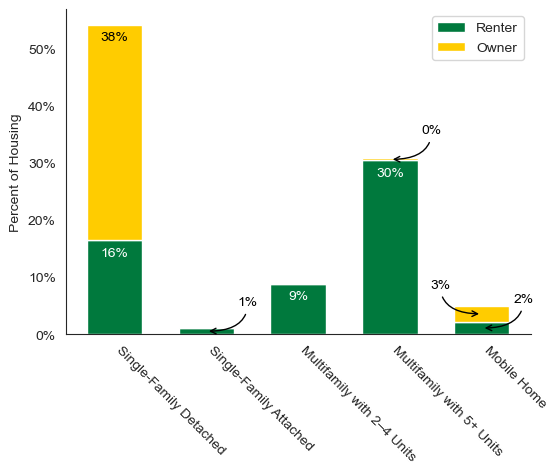

In [13]:
def update_bldg_type_names(x):
    y = x.replace("Multi-Family", "Multifamily")
    y = re.sub(r"(?<=\d)(\s*-\s*)(?=\d)", "\u2013", y)
    return y


data = (
    up00.groupby(
        [
            "build_existing_model.geometry_building_type_recs",
            "build_existing_model.tenure",
        ]
    )["sample_weight"]
    .sum()
    .unstack(level=1, fill_value=0.0)
    / Total_dwelling_unit_count
)
data = data.reindex(index=bldg_type_order, columns=["Renter", "Owner"])
data.index = data.index.map(update_bldg_type_names)

fig, ax = plt.subplots(figsize=(6, 5))
fig.subplots_adjust(bottom=0.3, top=0.95)
bar_width = 0.6
bottom = np.zeros(data.shape[0])

directions = defaultdict(lambda: 1)
for col, s in data.items():
    bars = ax.bar(s.index, s.values, bar_width, label=col, bottom=bottom)
    for i, bar in enumerate(bars):
        yval = bar.get_height()
        if yval == 0:
            continue
        kw = {}
        if yval > 0.04:
            luminance = np.dot([0.2126, 0.7152, 0.0722, 0], bar.get_facecolor())
            text_color = (0, 0, 0) if luminance > 0.5 else (1, 1, 1)
            xytext = (0, -0.5)
            yloc = yval + bar.get_y()
        else:
            text_color = (0, 0, 0)
            xytext = (3.0 * directions[i], 2.5)
            kw['arrowprops'] = {
                "arrowstyle": "->",
                "connectionstyle": "angle3",
                "color": (0, 0, 0),
            }
            yloc = yval / 2 + bar.get_y()
            directions[i] *= -1
        ax.annotate(
            "{:.0%}".format(yval),
            (bar.get_x() + bar.get_width() / 2, yloc),
            xytext=xytext,
            textcoords='offset fontsize',
            color=text_color,
            ha="center",
            va="top",
            **kw
        )
    bottom += s.values
ax.legend()
ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha="left")
ax.set_ylabel("Percent of Housing")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
sns.despine()
fig.savefig(fig_dir / "building_type_tenure_mpl.png", dpi=200)
fig.savefig(fig_dir / "building_type_tenure_mpl.svg")

In [14]:
# option 3 colors for income group
xcol = 'build_existing_model.geometry_building_type_recs'
ycol = 'build_existing_model.area_median_income'
data = (up00.groupby([xcol, ycol])['sample_weight'].sum() / Total_dwelling_unit_count).unstack().fillna(0.0)
data.sort_index(key=lambda x: x.str.extract(r"^(\d+)")[0].astype(int), axis='columns', inplace=True)
data = data.reindex(index=bldg_type_order)

fig = px.bar(data.reset_index(), x=xcol,
             y=data.columns.values,
             text_auto=True,
             color_discrete_sequence = ['rgb(0, 121, 61)',
                                        'rgb(255, 204, 0)',
                                        'rgb(130, 187, 39)',
                                        'rgb(0, 168, 226)',
                                        'rgb(255, 153, 51)',
                                        'rgb(0, 51, 153)',
                                        'rgb(204, 255, 102)'])
fig.update_traces(textfont_size=10, textangle=0, textposition="inside", cliponaxis=False)
fig.update_layout(autosize=False, width=400, height=370, 
                  font=dict(size=10), 
                  plot_bgcolor='rgba(0, 0, 0, 0)', 
                  title="Building Type",
                  legend_title="Area Median Income",
                  xaxis_title="",
                  yaxis_title="Percent of Housing",
                  yaxis_range=[0,0.6])
fig.layout.yaxis.tickformat = ',.0%'
fig.update_xaxes(tickangle=45)
fig.show()
fig.write_image(fig_dir / "building_type_income.svg")

In [15]:
xcol = 'build_existing_model.area_median_income'
ycol = 'build_existing_model.geometry_building_type_recs'
data2 = up00.groupby([xcol, ycol])['sample_weight'].sum().unstack().fillna(0.0)
data2.sort_index(key=lambda x: x.str.extract(r"^(\d+)")[0].astype(int), inplace=True)
data2 = data2.reindex(columns=bldg_type_order)
data2 = data2 / data2.sum().sum()
data2.columns = data2.columns.map(update_bldg_type_names)
cols = data2.columns.values
fig = px.bar(
    data2.reset_index(),
    x=xcol,
    y=cols,
    text_auto=True,
    color_discrete_sequence = ['rgb(0, 121, 61)',
                                'rgb(255, 204, 0)',
                                'rgb(130, 187, 39)',
                                'rgb(0, 168, 226)',
                                'rgb(255, 153, 51)']
)
fig.update_traces(textfont_size=10, textangle=0, textposition="inside", cliponaxis=False)
fig.update_layout(autosize=False, width=400, height=370, 
                  font=dict(size=10), 
                  plot_bgcolor='rgba(0, 0, 0, 0)', 
                  title="Building Type by Area Median Income",
                  legend_title="Building Type",
                  xaxis_title="Area Median Income",
                  yaxis_title="Percent of Housing",
                  yaxis_range=[0, 0.5])
fig.layout.yaxis.tickformat = ',.0%'
fig.update_xaxes(tickangle=45)
fig.show()
fig.write_image(fig_dir / 'income_building_type.svg')

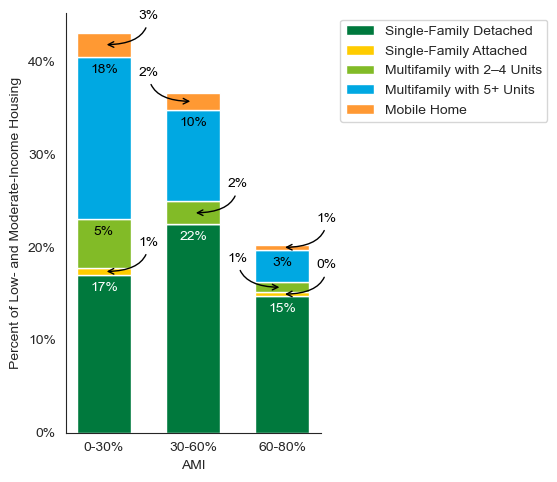

In [16]:
fig, ax = plt.subplots(figsize=(6, 5))
fig.subplots_adjust(right=0.55, top=0.95)
bottom = np.zeros(data2.shape[0])
directions = defaultdict(lambda: 1)
for idx, s in data2.items():
    bars = ax.bar(s.index, s.values, 0.6, bottom, label=idx)
    for i, bar in enumerate(bars):
        yval = bar.get_height()
        if yval == 0:
            continue
        kw = {}
        if yval > 0.03:
            luminance = np.dot([0.2126, 0.7152, 0.0722, 0], bar.get_facecolor())
            text_color = (0, 0, 0) if luminance > 0.5 else (1, 1, 1)
            xytext = (0, -0.5)
            yloc = yval + bar.get_y()
        else:
            text_color = (0, 0, 0)
            xytext = (3.2 * directions[i], 2.5)
            kw["arrowprops"] = {
                "arrowstyle": "->",
                "connectionstyle": "angle3",
                "color": (0, 0, 0),
            }
            yloc = yval / 2 + bar.get_y()
            if i > 0:
                directions[i] *= -1
        ax.annotate(
            f"{yval:.0%}",
            (bar.get_x() + bar.get_width() / 2, yloc),
            xytext=xytext,
            textcoords="offset fontsize",
            color=text_color,
            ha="center",
            va="top",
            **kw,
        )
    bottom += s.values

ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
ax.set_xlabel("AMI")
ax.set_ylabel("Percent of Low- and Moderate-Income Housing")
sns.despine()
fig.savefig(fig_dir / "income_building_type_mpl.png", dpi=200)
fig.savefig(fig_dir / "income_building_type_mpl.svg")

In [17]:
ax.get_xlim()

(-0.42999999999999994, 2.4299999999999997)

In [18]:
# option 4 
building_type_list = list(up00['build_existing_model.geometry_building_type_recs'].unique())
building_type_percentage = []
Total_energy_use = up00['report_simulation_output.energy_use_total_m_btu'].sum()
for building_type in building_type_list:
    temp = up00.loc[up00['build_existing_model.geometry_building_type_recs'] == building_type]
    temp_count =temp['report_simulation_output.energy_use_total_m_btu'].sum()/Total_energy_use
    building_type_percentage.append(temp_count)
    
fig = px.bar(x=bldg_type_order, y=building_type_percentage, text_auto=True)
fig.update_traces(textfont_size=10, textangle=0, textposition="outside", cliponaxis=False)
fig.update_traces(marker_color='rgb(0, 121, 61)', marker_line_color='rgb(0, 121, 61)')
fig.update_layout(autosize=False, width=300, height=300, 
                  font=dict(size=10), 
                  plot_bgcolor='rgba(0, 0, 0, 0)', 
                  title="Building Type",
                  xaxis_title="",
                  yaxis_title="Percent of Energy Use",
                 yaxis_range=[0,1])
fig.layout.yaxis.tickformat = ',.0%'
fig.update_xaxes(tickangle=45)
fig.show()
fig.write_image(fig_dir / "building_type_energy.svg")

### 3. Heating Fuel

In [19]:
#option 1  build_existing_model.heating_fuel
heating_fuel_list = ['electricity', 'natural_gas', 'propane', 'fuel_oil']
heating_fuel_figure = ['Electricity', 'Natural Gas', 'Propane', 'Fuel Oil']
heating_fuel_consumption = []
for heating_fuel in heating_fuel_list:
    temp = up00[f'report_simulation_output.end_use_{heating_fuel}_heating_m_btu'].sum() 
    heating_fuel_consumption.append(temp)
    
total_energy = sum(heating_fuel_consumption)
heating_fuel_percentage = heating_fuel_consumption/total_energy

fig = px.bar(x=heating_fuel_figure, y=heating_fuel_percentage, text_auto=True)
fig.update_traces(textfont_size=10, textangle=0, textposition="outside", cliponaxis=False)
fig.update_traces(marker_color='rgb(0, 121, 61)', marker_line_color='rgb(0, 121, 61)')
fig.update_layout(autosize=False, width=290, height=300, 
                  font=dict(size=10), 
                  plot_bgcolor='rgba(0, 0, 0, 0)', 
                  title="Heating Fuel",
                  xaxis_title="",
                  yaxis_title="Percent of Energy Use",
                 yaxis_range=[0,1])
fig.layout.yaxis.tickformat = ',.0%'
fig.update_xaxes(tickangle=45)
fig.show()
fig.write_image(fig_dir / "heating_fuel_energy.svg")

In [20]:
#option 2
type_list = list(up00['build_existing_model.heating_fuel'].unique())
type_percentage = []
for item in type_list:
    temp = up00.loc[up00['build_existing_model.heating_fuel'] == item]
    temp_count =temp['sample_weight'].sum()/Total_dwelling_unit_count
    type_percentage.append(temp_count)
    
fig = px.bar(x=type_list, y=type_percentage, text_auto=True)
fig.update_traces(textfont_size=10, textangle=0, textposition="outside", cliponaxis=False)
fig.update_traces(marker_color='rgb(0, 121, 61)', marker_line_color='rgb(0, 121, 61)')
fig.update_layout(autosize=False, width=290, height=300, 
                  font=dict(size=10), 
                  plot_bgcolor='rgba(0, 0, 0, 0)', 
                  title="Heating Fuel",
                  xaxis_title="",
                  yaxis_title="Percent of Housing",
                 yaxis_range=[0,0.8])
fig.layout.yaxis.tickformat = ',.0%'
fig.update_xaxes(tickangle=45)
fig.show()
fig.write_image(fig_dir / "heating_fuel_units.svg")

### 4. Cooling Type

In [21]:
cooling_type_list = list(up00['build_existing_model.hvac_cooling_type'].unique())
cooling_type_duct_percentage = []
cooling_type_noduct_percentage = []
for cooling_type in cooling_type_list:
    temp = up00.loc[up00['build_existing_model.hvac_cooling_type'] == cooling_type]
    temp_duct = temp.loc[temp['build_existing_model.hvac_has_ducts'] == 'Yes']
    temp_noduct = temp.loc[temp['build_existing_model.hvac_has_ducts'] == 'No']
    temp_duct_count =temp_duct['sample_weight'].sum()/Total_dwelling_unit_count
    temp_noduct_count =temp_noduct['sample_weight'].sum()/Total_dwelling_unit_count
    cooling_type_duct_percentage.append(temp_duct_count)
    cooling_type_noduct_percentage.append(temp_noduct_count)
data = pd.DataFrame()
data['cooling_type'] = cooling_type_list
data['Ducted'] = cooling_type_duct_percentage
data['Non-ducted'] =cooling_type_noduct_percentage
fig = px.bar(data, x="cooling_type", y=["Ducted", "Non-ducted"], text_auto=True, color_discrete_sequence = ['rgb(0, 121, 61)', 'rgb(255, 204, 0)'])
fig.update_traces(textfont_size=10, textangle=0, textposition="inside", cliponaxis=False)
#fig.update_traces(marker_color='rgb(0, 121, 61)', marker_line_color='rgb(0, 121, 61)')
fig.update_layout(autosize=False, width=340, height=300, 
                  font=dict(size=10), 
                  plot_bgcolor='rgba(0, 0, 0, 0)', 
                  title="Cooling Type",
                  xaxis_title="",
                  legend_title="Type",
                  yaxis_title="Percent of Housing",
                  yaxis_range=[0,0.6])
fig.layout.yaxis.tickformat = ',.0%'
fig.update_xaxes(tickangle=45)
fig.show()
fig.write_image(fig_dir / "cooling_type.svg")


### 5. Envelope Label

In [22]:
# for buildings with frame wall
frame_wall = up00.loc[up00['build_existing_model.geometry_wall_type'].isin(['Wood Frame', 'Steel Frame'])]
total_count = len(frame_wall)

wall_good = frame_wall.loc[frame_wall["wall_rating"]=="code-compliant"]
wall_inadequate = frame_wall.loc[frame_wall["wall_rating"]=="above-average"]
wall_good_count = len(wall_good)/total_count
wall_inadequate_count = len(wall_inadequate)/total_count
wall_poor_count = 1 - wall_good_count - wall_inadequate_count

ceiling_roof_good = frame_wall.loc[frame_wall["ceiling_roof_rating"]=="code-compliant"]
ceiling_roof_inadequate = frame_wall.loc[frame_wall["ceiling_roof_rating"]=="above-average"]
ceiling_roof_good_count = len(ceiling_roof_good)/total_count
ceiling_roof_inadequate_count = len(ceiling_roof_inadequate)/total_count
ceiling_roof_poor_count = 1 -ceiling_roof_good_count - ceiling_roof_inadequate_count

infiltration_good = frame_wall.loc[frame_wall["infiltration_rating"]=="code-compliant"]
infiltration_inadequate = frame_wall.loc[frame_wall["infiltration_rating"]=="above-average"]
infiltration_good_count = len(infiltration_good)/total_count
infiltration_inadequate_count = len(infiltration_inadequate)/total_count
infiltration_poor_count = 1 - infiltration_good_count - infiltration_inadequate_count

combined_envelope_good = frame_wall.loc[frame_wall["combined_envelope_rating"]=="code-compliant"]
combined_envelope_inadequate = frame_wall.loc[frame_wall["combined_envelope_rating"]=="above-average"]
combined_envelope_good_count = len(combined_envelope_good)/total_count
combined_envelope_inadequate_count = len(combined_envelope_inadequate)/total_count
combined_envelope_poor_count = 1 - combined_envelope_good_count - combined_envelope_inadequate_count

data = pd.DataFrame()
data['type'] = ['Wall', 'Ceiling Roof', 'Infiltration', 'Combined Envelope']
data['Good'] = [wall_good_count, ceiling_roof_good_count, infiltration_good_count, combined_envelope_good_count]
data['Inadequate'] = [wall_inadequate_count, ceiling_roof_inadequate_count, infiltration_inadequate_count, combined_envelope_inadequate_count]
data['Poor'] = [wall_poor_count, ceiling_roof_poor_count, infiltration_poor_count, combined_envelope_poor_count]
fig = px.bar(data, y="type", x=["Good", "Inadequate", "Poor"],
             text_auto=True,
             orientation='h',
             color_discrete_sequence = ['rgb(0, 121, 61)', 'rgb(130, 187, 39)', 'rgb(255, 204, 0)'])
fig.update_traces(textfont_size=10, textangle=0, textposition="inside", cliponaxis=False)
fig.update_layout(autosize=False, width=500, height=260, 
                  font=dict(size=10), 
                  plot_bgcolor='rgba(0, 0, 0, 0)', 
                  title="Envelope Status for Buildings with Frame Wall",
                  legend_title="Envelope Label",
                  yaxis_title="",
                  xaxis_title="Percent of Housing",
                  xaxis_range=[0,1])
fig.layout.xaxis.tickformat = ',.0%'
fig.show()
fig.write_image(fig_dir / "envelope_label_frame_wall.svg")

In [23]:
# for buildings with masonry wall
masonry_wall = up00.loc[up00['build_existing_model.geometry_wall_type'].isin(['Brick', 'Concrete'])]
total_count = len(masonry_wall)

wall_good = masonry_wall.loc[masonry_wall["wall_rating"]=="code-compliant"]
wall_inadequate = masonry_wall.loc[masonry_wall["wall_rating"]=="above-average"]
wall_good_count = len(wall_good)/total_count
wall_inadequate_count = len(wall_inadequate)/total_count
wall_poor_count = 1 - wall_good_count - wall_inadequate_count

ceiling_roof_good = masonry_wall.loc[masonry_wall["ceiling_roof_rating"]=="code-compliant"]
ceiling_roof_inadequate = masonry_wall.loc[masonry_wall["ceiling_roof_rating"]=="above-average"]
ceiling_roof_good_count = len(ceiling_roof_good)/total_count
ceiling_roof_inadequate_count = len(ceiling_roof_inadequate)/total_count
ceiling_roof_poor_count = 1 -ceiling_roof_good_count - ceiling_roof_inadequate_count

infiltration_good = masonry_wall.loc[masonry_wall["infiltration_rating"]=="code-compliant"]
infiltration_inadequate = masonry_wall.loc[masonry_wall["infiltration_rating"]=="above-average"]
infiltration_good_count = len(infiltration_good)/total_count
infiltration_inadequate_count = len(infiltration_inadequate)/total_count
infiltration_poor_count = 1 - infiltration_good_count - infiltration_inadequate_count

combined_envelope_good = masonry_wall.loc[masonry_wall["combined_envelope_rating"]=="code-compliant"]
combined_envelope_inadequate = masonry_wall.loc[masonry_wall["combined_envelope_rating"]=="above-average"]
combined_envelope_good_count = len(combined_envelope_good)/total_count
combined_envelope_inadequate_count = len(combined_envelope_inadequate)/total_count
combined_envelope_poor_count = 1 - combined_envelope_good_count - combined_envelope_inadequate_count

data = pd.DataFrame()
data['type'] = ['Wall', 'Ceiling Roof', 'Infiltration', 'Combined Envelope']
data['Good'] = [wall_good_count, ceiling_roof_good_count, infiltration_good_count, combined_envelope_good_count]
data['Inadequate'] = [wall_inadequate_count, ceiling_roof_inadequate_count, infiltration_inadequate_count, combined_envelope_inadequate_count]
data['Poor'] = [wall_poor_count, ceiling_roof_poor_count, infiltration_poor_count, combined_envelope_poor_count]
fig = px.bar(data, y="type", x=["Good", "Inadequate", "Poor"],
             text_auto=True,
             orientation='h',
             color_discrete_sequence = ['rgb(0, 121, 61)', 'rgb(130, 187, 39)', 'rgb(255, 204, 0)'])
fig.update_traces(textfont_size=10, textangle=0, textposition="inside", cliponaxis=False)
fig.update_layout(autosize=False, width=500, height=260, 
                  font=dict(size=10), 
                  plot_bgcolor='rgba(0, 0, 0, 0)', 
                  title="Envelope Status for Buildings with Masonry Wall",
                  legend_title="Envelope Label",
                  yaxis_title="",
                  xaxis_title="Percent of Housing",
                  xaxis_range=[0,1])
fig.layout.xaxis.tickformat = ',.0%'
fig.show()
fig.write_image(fig_dir / "envelope_label_masonry_wall.svg")


In [24]:
good = up00.loc[up00["combined_envelope_rating"]=="code-compliant"]
inadequate = up00.loc[up00["combined_envelope_rating"]=="above-average"]

total_count = len(up00)
good_count = len(good)/total_count
inadequate_count = len(inadequate)/total_count
poor_count = 1 - good_count - inadequate_count

fig = px.bar(x=['Good', 'Inadequate', 'Poor'], y=[good_count, inadequate_count, poor_count], text_auto=True)
fig.update_traces(textfont_size=10, textangle=0, textposition="outside", cliponaxis=False)
fig.update_traces(marker_color='rgb(0, 121, 61)', marker_line_color='rgb(0, 121, 61)')
fig.update_layout(autosize=False, width=250, height=300, 
                  font=dict(size=10), 
                  plot_bgcolor='rgba(0, 0, 0, 0)', 
                  title="Envelope Status",
                  xaxis_title="",
                  yaxis_title="Percent of Housing",
                  yaxis_range=[0,1])
fig.layout.yaxis.tickformat = ',.0%'
fig.update_xaxes(tickangle=45)
fig.show()
fig.write_image(fig_dir / "envelope_lable.svg")

### 6. Top Enduse

In [25]:
enduse_re = re.compile(r"report_simulation_output\.end_use_(\w+)_m_btu")

In [26]:
baseline_filename = f'data_/community_building_samples_with_upgrade_cost_and_bill/{community}/up00__{community}.parquet'

In [27]:
up00_pq = pq.ParquetFile(baseline_filename)
cols_to_load = list(filter(
    lambda x: re.match(enduse_re, x) or x in ('sample_weight', 'report_simulation_output.energy_use_total_m_btu', 'build_existing_model.area_median_income'),
    up00_pq.schema.names
))

In [28]:
up00 = pd.read_parquet(baseline_filename, engine='pyarrow', columns=cols_to_load)
up00 = up00[up00['build_existing_model.area_median_income'].isin(amis_to_keep)].copy()
del up00['build_existing_model.area_median_income']


In [29]:
for col in up00.columns:
    if up00[col].sum() == 0:
        del up00[col]

In [30]:
enduse_col_renames = {}
for col in up00.columns:
    m = enduse_re.match(col)
    if m:
        enduse_col_renames[col] = m.group(1)

In [31]:
up00.rename(columns=enduse_col_renames, inplace=True)

In [32]:
end_use_to_combine = defaultdict(list)
for enduse1 in ['heating', 'cooling', 'lighting']:
    for col in up00.columns:
        m = re.match(r"(electricity|natural_gas|fuel_oil|propane|coal|wood_cord|wood_pellet)_(\w+)", col)
        if not m:
            continue
        fuel, enduse2 = m.groups()
        if enduse2.startswith(enduse1):
            end_use_to_combine[f"{fuel}_{enduse1}"].append(col)
end_use_to_combine

defaultdict(list,
            {'electricity_heating': ['electricity_heating_fans_pumps',
              'electricity_heating_heat_pump_backup',
              'electricity_heating'],
             'natural_gas_heating': ['natural_gas_heating'],
             'propane_heating': ['propane_heating'],
             'electricity_cooling': ['electricity_cooling_fans_pumps',
              'electricity_cooling'],
             'electricity_lighting': ['electricity_lighting_exterior',
              'electricity_lighting_garage',
              'electricity_lighting_interior'],
             'natural_gas_lighting': ['natural_gas_lighting']})

In [33]:
for newcol, colstoadd in end_use_to_combine.items():
    print(newcol, colstoadd)
    s = up00[colstoadd].sum(axis=1)
    for col in colstoadd:
        del up00[col]
    up00[newcol] = s

electricity_heating ['electricity_heating_fans_pumps', 'electricity_heating_heat_pump_backup', 'electricity_heating']
natural_gas_heating ['natural_gas_heating']
propane_heating ['propane_heating']
electricity_cooling ['electricity_cooling_fans_pumps', 'electricity_cooling']
electricity_lighting ['electricity_lighting_exterior', 'electricity_lighting_garage', 'electricity_lighting_interior']
natural_gas_lighting ['natural_gas_lighting']


In [34]:
import itertools

In [35]:
enduse_cols = sorted(set(enduse_col_renames.values()).difference(itertools.chain(*end_use_to_combine.values())).union(end_use_to_combine.keys()))

In [36]:
set(up00.columns.values).difference(enduse_cols)

{'report_simulation_output.energy_use_total_m_btu', 'sample_weight'}

In [37]:
enduse_totals = up00[enduse_cols].multiply(up00['sample_weight'], axis='index').sum()

In [38]:
enduse_totals.sum()

398997.2445792364

In [39]:
(up00['report_simulation_output.energy_use_total_m_btu'] * up00['sample_weight']).sum()

398994.6357513474

In [40]:
enduse_pcts = (enduse_totals / enduse_totals.sum()).sort_values(ascending=False)

In [41]:
threshold = 0.02
enduse_pcts_top = enduse_pcts[enduse_pcts > threshold].copy()
enduse_pcts_other = enduse_pcts[enduse_pcts <= threshold].copy()
enduse_pcts_top['electricity_other'] = enduse_pcts_other[enduse_pcts_other.index.str.startswith('electricity')].sum()
enduse_pcts_top['natural_gas_other'] = enduse_pcts_other[enduse_pcts_other.index.str.startswith('natural_gas')].sum()
enduse_pcts_top.sort_values(ascending=True, inplace=True)
enduse_pcts_top

natural_gas_other           0.014742
electricity_refrigerator    0.031445
electricity_lighting        0.050421
electricity_hot_water       0.051092
electricity_other           0.056305
natural_gas_hot_water       0.071775
electricity_plug_loads      0.121332
electricity_heating         0.143715
natural_gas_heating         0.223365
electricity_cooling         0.225137
dtype: float64

In [42]:
enduse_pcts_top.sum()

0.9893295625725786

In [43]:
circles = circlify.circlify(enduse_pcts_top.tolist())

In [44]:
fig = go.Figure()
for c, enduse_col, pct in zip(circles, enduse_pcts_top.index.values, enduse_pcts_top.values):
    m = re.match(r"(electricity|natural_gas|fuel_oil|propane|coal|wood_cord|wood_pellet)_(\w+)", enduse_col)
    if m:
        fuel, enduse = m.groups()
        label_txt = f"{fuel}<br>{enduse}<br>{pct:.0%}".replace('_', ' ')
    else:
        label_txt = enduse_col.replace('_', ' ')
    label_txt = label_txt.capitalize()
    fig.add_shape(
        type='circle',
        x0=c.x-c.r,
        y0=c.y-c.r,
        x1=c.x+c.r,
        y1=c.y+c.r,
        fillcolor='rgb(0, 121, 61)' if fuel == 'electricity' else 'rgb(255, 204, 0)',
        line_width=0,
        label={
            'text': label_txt,
            'font': dict(
                size=12,
                color='rgb(255, 255, 255)' if fuel == 'electricity' else 'rgb(50, 50, 50)'
            )
        }
        
    )
fig.update_layout(autosize=False, width=650, height=650, 
                  font=dict(size=10), 
                  plot_bgcolor='rgba(0, 0, 0, 0)', 
                  title="Top End Uses",
                  xaxis_title="",
                  yaxis_title="",
                  yaxis_range=[0,0.8])
fig.update_xaxes(
    range=[-1, 1],
    showticklabels=False
)
fig.update_yaxes(
    range=[-1.01, 1.01],
    showticklabels=False
)
fig.show()
fig.write_image(fig_dir / "enduse_bubble.svg")

In [45]:
up00 = pd.read_parquet(f'data_/community_building_samples_with_upgrade_cost_and_bill/{community}/up00__{community}.parquet', engine='pyarrow')
up00 = up00[up00['build_existing_model.area_median_income'].isin(amis_to_keep)].copy()


### 7. Energy Burden

In [46]:
#option 1
metric = "energy_burden"
metric_name = metric.replace("_", " ").title()

type_list = ['<2%', '2-4%', '4-6%', '6-8%', '8-10%', '10%+']
type_percentage = []
for item in type_list:
    temp = up_baseline.loc[up_baseline[metric] == item]
    temp_count =temp['sample_weight'].sum()/up_baseline["sample_weight"].sum()
    type_percentage.append(temp_count)
    
fig = px.bar(x=type_list, y=type_percentage, text_auto=True)
fig.update_traces(textfont_size=10, textangle=0, textposition="outside", cliponaxis=False)
fig.update_traces(marker_color='rgb(0, 121, 61)', marker_line_color='rgb(0, 121, 61)')
fig.update_layout(autosize=False, width=350, height=300, 
                  font=dict(size=10), 
                  plot_bgcolor='rgba(0, 0, 0, 0)', 
                  title=metric_name,
                  xaxis_title="",
                  yaxis_title="Percent of Housing",
                  yaxis_range=[0,0.4])
fig.layout.yaxis.tickformat = ',.0%'
fig.update_xaxes(tickangle=45)
fig.show()
fig.write_image(fig_dir / f"{metric}.svg")

In [47]:
#option 2
metric = "energy_burden"
metric_name = metric.replace("_", " ").title()

type_list = ['<2%', '2-4%', '4-6%', '6-8%', '8-10%', '10%+']
type_percentage = []
for item in type_list:
    temp = up_baseline.loc[up_baseline[metric] == item]
    temp_count =temp['sample_weight'].sum()/up_baseline["sample_weight"].sum()
    type_percentage.append(temp_count)
    
fig = px.bar(x=type_list, y=type_percentage, text_auto=False)
fig.update_traces(marker_color='rgb(0, 121, 61)', marker_line_color='rgb(0, 121, 61)')
fig.update_layout(autosize=False, width=350, height=300, 
                  font=dict(size=10), 
                  plot_bgcolor='rgba(0, 0, 0, 0)', 
                  title=metric_name,
                  xaxis_title="",
                  yaxis_title="Percent of Housing",
                  yaxis_range=[0,0.4])
fig.layout.yaxis.tickformat = ',.0%'
fig.update_xaxes(tickangle=45)
fig.show()
fig.write_image(fig_dir / f"{metric}_2.svg")

In [48]:
#option 3
metric = "energy_burden"
metric_name = metric.replace("_", " ").title()
type_list =  ['<2%', '2-4%', '4-6%', '6-8%', '8-10%', '10%+']

fuel_1_percentage = []
fuel_2_percentage = []
fuel_3_percentage = []
fuel_4_percentage = []
fuel_5_percentage = []
fuel_6_percentage = []
for item in type_list:
    temp = up_baseline.loc[up_baseline[metric] == item]
    temp_1 = temp.loc[temp['build_existing_model.heating_fuel'] == 'Electricity']
    temp_2 = temp.loc[temp['build_existing_model.heating_fuel'] == 'Natural Gas']
    temp_3 = temp.loc[temp['build_existing_model.heating_fuel'] == 'Propane']
    temp_4 = temp.loc[temp['build_existing_model.heating_fuel'] == 'Fuel Oil']
    temp_5 = temp.loc[temp['build_existing_model.heating_fuel'] == 'Other Fuel']
    temp_6 = temp.loc[temp['build_existing_model.heating_fuel'] == 'None']
    fuel_1_percentage.append(temp_1['sample_weight'].sum()/up_baseline["sample_weight"].sum())
    fuel_2_percentage.append(temp_2['sample_weight'].sum()/up_baseline["sample_weight"].sum())
    fuel_3_percentage.append(temp_3['sample_weight'].sum()/up_baseline["sample_weight"].sum())
    fuel_4_percentage.append(temp_4['sample_weight'].sum()/up_baseline["sample_weight"].sum())
    fuel_5_percentage.append(temp_5['sample_weight'].sum()/up_baseline["sample_weight"].sum())
    fuel_6_percentage.append(temp_6['sample_weight'].sum()/up_baseline["sample_weight"].sum())
data = pd.DataFrame()
data['type'] = type_list
data['Electricity'] = fuel_1_percentage
data['Natural Gas'] = fuel_2_percentage
data['Propane'] = fuel_3_percentage
data['Fuel Oil'] = fuel_4_percentage
data['Other Fuel'] = fuel_5_percentage
data['None'] = fuel_6_percentage

fig = px.bar(data, x="type",
             y=['Electricity', 'Natural Gas', 'Propane', 'Fuel Oil', 'Other Fuel', 'None'],
             text_auto=True,
             color_discrete_sequence = ['rgb(0, 121, 61)',
                                        'rgb(255, 204, 0)',
                                        'rgb(130, 187, 39)',
                                        'rgb(0, 168, 226)',
                                        'rgb(255, 153, 51)',
                                        'rgb(0, 51, 153)'])
fig.update_traces(textfont_size=10, textangle=0, textposition="inside", cliponaxis=False)
fig.update_layout(autosize=False, width=410, height=300, 
                  font=dict(size=10), 
                  plot_bgcolor='rgba(0, 0, 0, 0)', 
                  title=metric_name,
                  legend_title="Heating Fuel",
                  xaxis_title="",
                  yaxis_title="Percent of Housing",
                  yaxis_range=[0,0.4])
fig.layout.yaxis.tickformat = ',.0%'
fig.update_xaxes(tickangle=45)
fig.show()
fig.write_image(fig_dir / f"{metric}_heating_fuel.svg")

In [49]:
#option 4
metric = "energy_burden"
metric_name = metric.replace("_", " ").title()
type_list =  ['<2%', '2-4%', '4-6%', '6-8%', '8-10%', '10%+']

income_1_percentage = []
income_2_percentage = []
income_3_percentage = []
income_4_percentage = []
income_5_percentage = []
income_6_percentage = []
income_7_percentage = []
for item in type_list:
    temp = up_baseline.loc[up_baseline[metric] == item]
    temp_1 = temp.loc[temp['build_existing_model.area_median_income'] == '0-30%']
    temp_2 = temp.loc[temp['build_existing_model.area_median_income'] == '30-60%']
    temp_3 = temp.loc[temp['build_existing_model.area_median_income'] == '60-80%']
    temp_4 = temp.loc[temp['build_existing_model.area_median_income'] == '80-100%']
    temp_5 = temp.loc[temp['build_existing_model.area_median_income'] == '100-120%']
    temp_6 = temp.loc[temp['build_existing_model.area_median_income'] == '120-150%']
    temp_7 = temp.loc[temp['build_existing_model.area_median_income'] == '150%+']
    income_1_percentage.append(temp_1['sample_weight'].sum()/up_baseline["sample_weight"].sum())
    income_2_percentage.append(temp_2['sample_weight'].sum()/up_baseline["sample_weight"].sum())
    income_3_percentage.append(temp_3['sample_weight'].sum()/up_baseline["sample_weight"].sum())
    income_4_percentage.append(temp_4['sample_weight'].sum()/up_baseline["sample_weight"].sum())
    income_5_percentage.append(temp_5['sample_weight'].sum()/up_baseline["sample_weight"].sum())
    income_6_percentage.append(temp_6['sample_weight'].sum()/up_baseline["sample_weight"].sum())
    income_7_percentage.append(temp_7['sample_weight'].sum()/up_baseline["sample_weight"].sum())
data = pd.DataFrame()
data['type'] = type_list
data['0-30%'] = income_1_percentage
data['30-60%'] = income_2_percentage
data['60-80%'] = income_3_percentage
data['80-100%'] = income_4_percentage
data['100-120%'] = income_5_percentage
data['120-150%'] = income_6_percentage
data['150%+'] = income_7_percentage

fig = px.bar(data, x="type",
             y=['0-30%','30-60%','60-80%','80-100%', '100-120%','120-150%', '150%+'],
             text_auto=True,
             color_discrete_sequence = ['rgb(0, 121, 61)',
                                        'rgb(255, 204, 0)',
                                        'rgb(130, 187, 39)',
                                        'rgb(0, 168, 226)',
                                        'rgb(255, 153, 51)',
                                        'rgb(0, 51, 153)',
                                        'rgb(204, 255, 102)'])
fig.update_traces(textfont_size=10, textangle=0, textposition="inside", cliponaxis=False)
fig.update_layout(autosize=False, width=410, height=300, 
                  font=dict(size=10), 
                  plot_bgcolor='rgba(0, 0, 0, 0)', 
                  title=metric_name,
                  legend_title="Area Median Income",
                  xaxis_title="",
                  yaxis_title="Percent of Housing",
                  yaxis_range=[0,0.4])
fig.layout.yaxis.tickformat = ',.0%'
fig.update_xaxes(tickangle=45)
fig.show()
fig.write_image(fig_dir / f"{metric}_income.svg")

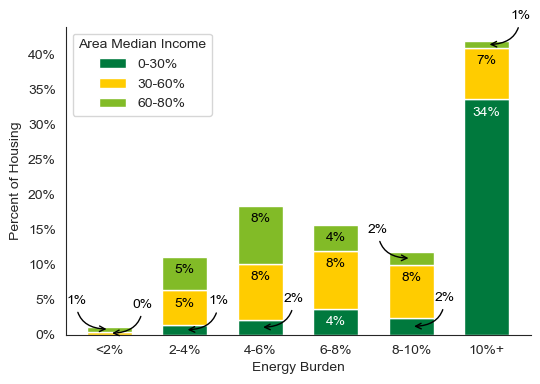

In [50]:
xcol = 'build_existing_model.area_median_income'
ycol = 'energy_burden'
data2 = up_baseline.groupby([xcol, ycol])['sample_weight'].sum().unstack().fillna(0.0).reindex(columns=type_list)
data2 = data2 / data2.sum().sum()


fig, ax = plt.subplots(figsize=(6, 4))
bottom = np.zeros(data2.shape[1])
directions = defaultdict(lambda: 1)
for idx, s in data2.iterrows():
    bars = ax.bar(s.index, s.values, width=0.6, bottom=bottom, label=idx)
    for i, bar in enumerate(bars):
        yval = bar.get_height()
        if yval == 0:
            continue
        kw = {}
        if yval > 0.03:
            luminance = np.dot([0.2126, 0.7152, 0.0722, 0], bar.get_facecolor())
            text_color = (0, 0, 0) if luminance > 0.5 else (1, 1, 1)
            xytext = (0, -0.5)
            yloc = yval + bar.get_y()
        else:
            text_color = (0, 0, 0)
            xytext = (2.4 * directions[i], 2.5)
            kw["arrowprops"] = {
                "arrowstyle": "->",
                "connectionstyle": "angle3",
                "color": (0, 0, 0),
            }
            yloc = yval / 2 + bar.get_y()
            directions[i] *= -1
        ax.annotate(
            f"{yval:.0%}",
            (bar.get_x() + bar.get_width() / 2, yloc),
            xytext=xytext,
            textcoords="offset fontsize",
            color=text_color,
            ha="center",
            va="top",
            **kw,
        )
    bottom += s.values
ax.legend(loc='upper left', title="Area Median Income")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
ax.set_xlabel("Energy Burden")
ax.set_ylabel("Percent of Housing")
sns.despine()
fig.savefig(fig_dir / f"{metric}_income_mpl.svg")
fig.savefig(fig_dir / f"{metric}_income_mpl.png", dpi=200)


In [51]:
data2

energy_burden,<2%,2-4%,4-6%,6-8%,8-10%,10%+
build_existing_model.area_median_income,,,,,,
0-30%,0.000000,0.014131,0.021197,0.036592,0.023716,0.335498
30-60%,0.004301,0.048968,0.080030,0.083234,0.076010,0.073816
60-80%,0.007373,0.047616,0.082698,0.037171,0.018739,0.008909


### 8. Efficiency of Heating System

In [52]:
[x for x in up00.columns if x.startswith('build_existing_model.hvac_heating_')]

['build_existing_model.hvac_heating_efficiency',
 'build_existing_model.hvac_heating_type',
 'build_existing_model.hvac_heating_type_and_fuel']

In [53]:
htg_types = up00.groupby('build_existing_model.hvac_heating_type_and_fuel')['sample_weight'].sum() / Total_dwelling_unit_count
htg_types

build_existing_model.hvac_heating_type_and_fuel
Electricity ASHP                       0.171618
Electricity Baseboard                  0.050688
Electricity Electric Boiler            0.001843
Electricity Electric Furnace           0.282432
Electricity Electric Wall Furnace      0.003686
Electricity Shared Heating             0.068806
Natural Gas Fuel Boiler                0.040551
Natural Gas Fuel Furnace               0.335402
Natural Gas Fuel Wall/Floor Furnace    0.020275
Natural Gas Shared Heating             0.017326
Propane Fuel Furnace                   0.007373
Name: sample_weight, dtype: float64

In [54]:
fig = px.bar(
    x=htg_types.index,
    y=htg_types.values,
    text_auto=True
)
fig.update_traces(textfont_size=10, textangle=0, textposition="outside", cliponaxis=False)
bar_colors = ['rgb(0, 121, 61)' if x.startswith('Electricity') else 'rgb(255, 204, 0)'
              for x in htg_types.index]
fig.update_traces(
    marker_color=bar_colors,
    marker_line_color=bar_colors
)
fig.update_layout(autosize=False, width=700, height=300, 
                  font=dict(size=10), 
                  plot_bgcolor='rgba(0, 0, 0, 0)', 
                  title="Heating System Types",
                  xaxis_title="",
                  yaxis_title="Percent of Housing")
fig.layout.yaxis.tickformat = ',.0%'
fig.update_xaxes(tickangle=45)
fig.show()
fig.write_image(fig_dir / "heating_types.svg")

In [55]:
htg_effs = up00.groupby([
    'build_existing_model.heating_fuel',
    'build_existing_model.hvac_heating_efficiency',
])['sample_weight'].sum() / Total_dwelling_unit_count
htg_effs = htg_effs.loc[['Electricity', 'Natural Gas']]

In [56]:
fig = px.bar(
    x=htg_effs.index.get_level_values(1),
    y=htg_effs.values,
    text_auto=True
)
fig.update_traces(textfont_size=10, textangle=0, textposition="outside", cliponaxis=False)
bar_colors = ['rgb(0, 121, 61)' if x == 'Electricity' else 'rgb(255, 204, 0)'
              for x in htg_effs.index.get_level_values(0)]
fig.update_traces(
    marker_color=bar_colors,
    marker_line_color=bar_colors
)
fig.update_layout(autosize=False, width=700, height=300, 
                  font=dict(size=10), 
                  plot_bgcolor='rgba(0, 0, 0, 0)', 
                  title="Efficiency of Heating Systems",
                  xaxis_title="",
                  yaxis_title="Percent of Housing",
                 yaxis_range=[0,0.3])
fig.layout.yaxis.tickformat = ',.0%'
fig.update_xaxes(tickangle=45)
fig.show()

In [57]:
heating_eff_list = sorted(up00['build_existing_model.hvac_heating_efficiency'].unique().tolist())
heating_eff_percentage = []
for item in heating_eff_list:
    temp = up00.loc[up00['build_existing_model.hvac_heating_efficiency'] == item]
    temp_count =temp['sample_weight'].sum()/Total_dwelling_unit_count
    heating_eff_percentage.append(temp_count)
    
fig = px.bar(x=heating_eff_list, y=heating_eff_percentage, text_auto=True)
fig.update_traces(textfont_size=10, textangle=0, textposition="outside", cliponaxis=False)
fig.update_traces(marker_color='rgb(0, 121, 61)', marker_line_color='rgb(0, 121, 61)')
fig.update_layout(autosize=False, width=700, height=300, 
                  font=dict(size=10), 
                  plot_bgcolor='rgba(0, 0, 0, 0)', 
                  title="Efficiency of Heating Systems",
                  xaxis_title="",
                  yaxis_title="Percent of Housing",
                 yaxis_range=[0,0.3])
fig.layout.yaxis.tickformat = ',.0%'
fig.update_xaxes(tickangle=45)
fig.show()
fig.write_image(fig_dir / "heating_efficiency.svg")

### 9. Efficiency of Cooling System

In [58]:
cooling_eff_list = sorted(up00['build_existing_model.hvac_cooling_efficiency'].unique().tolist())
cooling_eff_percentage = []
for item in cooling_eff_list:
    temp = up00.loc[up00['build_existing_model.hvac_cooling_efficiency'] == item]
    temp_count =temp['sample_weight'].sum()/Total_dwelling_unit_count
    cooling_eff_percentage.append(temp_count)
    
fig = px.bar(x=cooling_eff_list, y=cooling_eff_percentage, text_auto=True)
fig.update_traces(textfont_size=10, textangle=0, textposition="outside", cliponaxis=False)
fig.update_traces(marker_color='rgb(0, 121, 61)', marker_line_color='rgb(0, 121, 61)')
fig.update_layout(autosize=False, width=500, height=300, 
                  font=dict(size=10), 
                  plot_bgcolor='rgba(0, 0, 0, 0)', 
                  title="Efficiency of Cooling Systems",
                  xaxis_title="",
                  yaxis_title="Percent of Housing",
                 yaxis_range=[0,0.3])
fig.layout.yaxis.tickformat = ',.0%'
fig.update_xaxes(tickangle=45)
fig.show()
fig.write_image(fig_dir / "cooling_efficiency.svg")

### 10. Percentage of Housing Available for Each Upgrade

In [59]:
Total_dwelling_unit = up_baseline["sample_weight"].sum()
type_list = community_results['upgrade_name'].unique().tolist()
type_list.remove('baseline')
type_percentage = []
for item in type_list:
    temp = community_results.loc[community_results["upgrade_name"] == item]
    temp_count =temp['sample_weight'].sum()/Total_dwelling_unit
    type_percentage.append(temp_count)
    
fig = px.bar(x=type_list, y=type_percentage, text_auto=True)
fig.update_traces(textfont_size=10, textangle=0, textposition="outside", cliponaxis=False)
fig.update_traces(marker_color='rgb(0, 121, 61)', marker_line_color='rgb(0, 121, 61)')
fig.update_layout(autosize=False, width=900, height=400, 
                  font=dict(size=10), 
                  plot_bgcolor='rgba(0, 0, 0, 0)', 
                  title="Applicability",
                  xaxis_title="",
                  yaxis_title="Percent of Housing",
                 yaxis_range=[0,1])
fig.layout.yaxis.tickformat = ',.0%'
fig.update_xaxes(tickangle=45)
fig.show()
fig.write_image(fig_dir / "upgrade_applicability.svg")

### 11. Tenure

In [60]:
type_list = list(up00['build_existing_model.tenure'].unique())
type_percentage = []
for item in type_list:
    temp = up00.loc[up00['build_existing_model.tenure'] == item]
    temp_count =temp['sample_weight'].sum()/Total_dwelling_unit_count
    type_percentage.append(temp_count)
    
fig = px.bar(x=type_list, y=type_percentage, text_auto=True)
fig.update_traces(textfont_size=10, textangle=0, textposition="outside", cliponaxis=False)
fig.update_traces(marker_color='rgb(0, 121, 61)', marker_line_color='rgb(0, 121, 61)')
fig.update_layout(autosize=False, width=240, height=300, 
                  font=dict(size=10), 
                  plot_bgcolor='rgba(0, 0, 0, 0)', 
                  title="Tenure",
                  xaxis_title="",
                  yaxis_title="Percent of Housing",
                 yaxis_range=[0,0.6])
fig.layout.yaxis.tickformat = ',.0%'
fig.update_xaxes(tickangle=45)
fig.show()
fig.write_image(fig_dir / "tenure.svg")